<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/37_Ultra_Lite_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Перепишите вариационный автокодировщик на базе Mnist с нуля в новом ноутбуке. Можно подсматривать в ноутбук занятия, но лучше писать код своими руками, а не копировать

In [1]:
!pip install keras==2.0 -q #загружаем 2ю версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.2 -q # загружаем эту версию тензорфлоу для корректной работы скрипта

     |████████████████████████████████| 191 kB 9.8 MB/s 
     |████████████████████████████████| 458.3 MB 15 kB/s 
     |████████████████████████████████| 458.3 MB 15 kB/s 
     |████████████████████████████████| 132 kB 70.4 MB/s 
     |████████████████████████████████| 458.3 MB 13 kB/s 
     |████████████████████████████████| 454.4 MB 29 kB/s 
     |████████████████████████████████| 4.0 MB 54.1 MB/s 
     |████████████████████████████████| 1.2 MB 67.4 MB/s 
     |████████████████████████████████| 462 kB 87.7 MB/s 
     |████████████████████████████████| 92.7 MB 1.1 MB/s 
     |████████████████████████████████| 3.2 MB 50.3 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 367 kB 8.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.13.2 whic

In [28]:
import sys # модуль содержит параметры и функции среды Python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
from scipy.stats import multivariate_normal

# from keras.datasets import mnist - сработало без tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.layers import Input, Dense, LeakyReLU # LeakyReLU - слой активацтт в последнее время хорошо работает в АЕ
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Reshape, Lambda  
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети
from tensorflow.keras.losses import binary_crossentropy #импортируем функцию потерь
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

from tensorflow.keras import backend as K # устанавливаем переменную для окружения Кераса (мы не можем пользоваться np или math библ-ми , только керасовскими модулями в которых также есть эти функции)
from IPython.display import clear_output #импортируем модуль очистки output'a


In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist

x_train = x_train.astype('float32')/255. # представляем x_train в виде значений от 0 до 1
x_test = x_test.astype('float32')/255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28,28,1)) # меняем размер на нужный нам
x_test = np.reshape(x_test, (len(x_test), 28,28,1)) # меняем размер на нужный нам


In [30]:
# создаем переменные с гиперпараметрами
batch_size = 100 # размер батча
latent_dim = 10 # размер скрытого (латентного , embedding) слоя
dropout_rate = 0.3 # размер слоя регуляризации, "включим" указанное количество нейронов
start_lr = 0.0001 # шаг обучения

In [31]:
def create_vae():  # создаем функцию автокодировщика
  models = {}      # задаем словарь моделей

  #Добавим Dropout и BatchNormalization
  def apply_bn_and_dropout(x):    #функция будет принимать на вход слой х
    return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

  #Энкодер
  input_img = Input(batch_shape = (batch_size, 28,28,1)) # размерности батч, строк, строк, столбцов, фильтров одной картинки 
  
  x = Flatten()(input_img)
  x = Dense(256, activation='relu')(x) # сплющиваем данные
  x = apply_bn_and_dropout(x) # применяем функцию регуляризации  нормализации 
  x = Dense(128, activation='relu')(x)
  x = apply_bn_and_dropout(x)

  # Предсказываем параметры распределений
  # Вместо того, чтобы предсказывать стандартное отклонеие, предсказываем логарифм вариции 

  z_mean = Dense(latent_dim)(x) # скртое пространство мат ожидание (мю) размером 10

  z_log_var = Dense(latent_dim)(x) # cкртое пространство (логарифм вариации) размером 10 (сигма)

  # Сэмплирование из Q c трюком репараметризации
  def sampling(args): # объявляем функцию сэмплирования
    z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
    
    # Керасовским методом делаем нормальное распределение (500 10тимерных), мат.ожидание 0, станд. откл 1
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

    return z_mean + K.exp(z_log_var / 2) * epsilon
  
  # Задаем самописный слой, который принимает лист [z_mean, z_log_var], семплирует и на выходе дает размерность (10,)
  l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  models['encoder'] = Model(input_img, l) # модель энкодера от входа до лямбда слоя
  models['z_meaner'] = Model(input_img, z_mean) # отдельная модель с путем от входа до z_mean
  models['z_lvarer'] = Model(input_img, z_log_var) # отдельная модель с путем от входа до z_log_var

  # Декодер
  z = Input(shape=(latent_dim,)) # задаем входную размерность (10,)
  x = Dense(128)(z) # полносвязный слой на 128 нейронов
  x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
  x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации 
  x = Dense(256)(x)  
  x = LeakyReLU()(x) 
  x = apply_bn_and_dropout(x)
  x = Dense(28*28, activation='sigmoid')(x) #полносвязный слой на 784 нейрона
  decoded = Reshape((28,28,1))(x) #меняем форму и приводим к нужным нам размерам
  
  models['decoder'] = Model(z, decoded, name = 'Decoder') # собираем модель декодера
  
  # Собираем вариационный автокодировщик
  models['vae'] = Model(input_img, models['decoder'](models['encoder'](input_img)), name = 'vae')  

  def vae_loss(x, decoded): # объявляем самописную функцию потерь
    x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры 'x' в одномерный через керасовскую функцию
    decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры 'decoded' в одномерный через керасовскую функцию
    xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между 'x' и 'decoded' с учетом пикселей
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss

    return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей
  return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models['vae'] # задаем модель вариационного автокодировщика

   


In [32]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь 

In [41]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors = False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
  args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
  n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси в аргументах
  figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

  for i in range(n):
    for j in range(len(args)): # заполняем фигуру значениями
      figure[j * digit_size: (j + 1) * digit_size,
             i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

  if invert_colors: # если значение invert_colors = True
    figure = 1-figure #  то фигуру делаем обратной

  plt.figure(figsize=(2*n, 2*len(args))) # отображаем фигуру с заданными значениями
  plt.imshow(figure, cmap='Greys_r') # выведем на экран в указанных цветах
  plt.grid(False) # указываем, что сетка не нужна
  ax = plt.gca() # получаем текущий объект Axes
  ax.get_xaxis().set_visible(False) # ось координат х делаем невидимой
  ax.get_yaxis().set_visible(False) # ось координат у делаем невидимой
  plt.show()

n = 15 # картинка 15х15 цифр
digit_size = 28


In [42]:
# Массивы в которые будем сохранять результаты для последующей визуализации
latent_distrs = []
epochs = []

# эпохи в которые будем сохранять
save_epochs = set([i*5 for i in range(0, 25)])

# отслеживать будем вот на этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator = models['decoder']
encoder_mean = models['z_meaner']

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
  if epoch in save_epochs:
    clear_output() # не захламляем аутпут

    # Сравниваем реальные и декодированные цифры
    decoded = vae.predict(imgs, batch_size = batch_size)
    plot_digits(imgs[:n_compare], decoded[:n_compare])

    # Cохранение многообразия и распределения z для создания анимации после
    epochs.append(epoch)
    latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбеки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

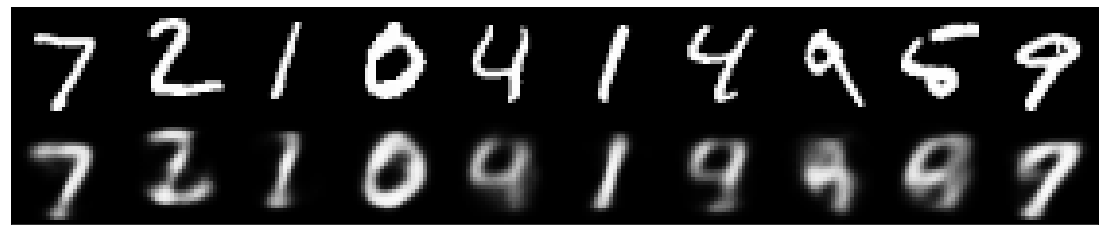

60000/60000 [==============================] - 12s 205us/sample - loss: 0.0991 - val_loss: 0.0881
Epoch 2/5
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0974 - val_loss: 0.0867
Epoch 3/5
60000/60000 [==============================] - 12s 200us/sample - loss: 0.0961 - val_loss: 0.0856
Epoch 4/5
60000/60000 [==============================] - 12s 201us/sample - loss: 0.0952 - val_loss: 0.0848
Epoch 5/5
60000/60000 [==============================] - 12s 201us/sample - loss: 0.0944 - val_loss: 0.0841


In [43]:

# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=5,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим данные в модель и задаем апраметры обучение